### Configuración

Primero se cargan las librerías necesarias para el desarrollo del _notebook_

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from yaml import safe_load
from scipy.stats import bernoulli, norm

Ahora se definen rutas relativas al _notebook_, para una adecuada manipulación de archivos dentro del directorio raíz.

In [2]:
# Ruta a directorio raíz
ROOT = os.path.dirname(os.getcwd())

# Abrir archivo de configuración
with open(file=os.path.join(ROOT, 'config.yml'), mode='r') as _file:
    CONFIG = safe_load(_file)
_file.close()

# 1. Regla de actualización

Revisar el **ejemplo 5.3.** del libro _Doing Bayesian Data Analyis_, J. Kruschke, 2° Edición.

Este _notebook_ es un ejemplo práctico de la regla de actualización utilizada en análisis de datos Bayesiano, usando como ejemplo lanzamientos de una moneda, es decir, el modelo de datos que describe el problema es una distribución Bernoulli.

$$p(y|\theta) = \theta^y (1 - \theta)^{1-y}$$

Para ilustrarlo, considera que existe una fábrica de monedas cuyo proceso de manufactura resulta en monedas cargadas a una cara con parámetro $\theta\in[0.0,0.1,...,0.9,1.0]$. Supón que nuestro conocimiento inicial del problema sugiere que la fábrica tiende a producir monedas justas ($\theta=0.5$), y que cualquier otra moneda tiene menor probabilidad de ser producida.

El conocimiento inicial se puede representar con la siguiente distribución triangular:

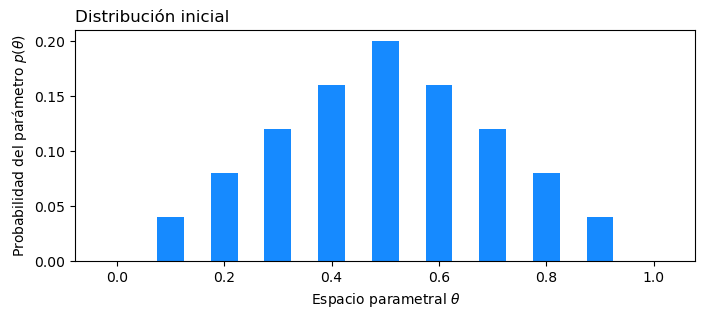

In [3]:
n = 11

datos = (
    # Iniciar objeto dataframe
    pd.DataFrame(
        # Datos iniciales
        data = {
            # Parámetro de la moneda
            'theta': np.linspace(start=0, stop=1, num=n)})
    # Columnas calculadas de la tabla
    .assign(
        # Distribución triangular de probabilidad para parámetro theta
        _p_theta = lambda table: np.minimum(table.theta, 1 - table.theta)
        # Condición de suma 1 para p_theta
        ,p_theta = lambda table: table._p_theta / table._p_theta.sum())
)

# Eliminar columnas temporales
datos.drop(
    columns = [col for col in datos.columns if col.startswith('_')]
    ,inplace=True)

# Configuración de figura
fig, ax = plt.subplots(figsize=(8,3))

# Elementos de visualización
ax.bar(
    x = datos.theta
    ,height = datos.p_theta
    ,width = 0.05
    ,color = CONFIG['graficas']['colors']['azul'])

# Anotaciones de figura
ax.set_title(f'Distribución inicial', loc='left')
ax.set_xlabel(r'Espacio parametral $\theta$')
ax.set_ylabel(r'Probabilidad del parámetro $p(\theta)$')

plt.show()

Definimos una función para evaluar $p(y|\theta)$ dado un valor de $y$:

In [4]:
def bernoulli_pdf(y):
    return lambda theta: theta**y * (1 - theta)**(1-y)

El siguiente paso sería obtener datos ($D$) para reubicar nuestro estado de conocimiento.

Supón que hacemos un lanzamiento de moneda y el resultado es $y=1$. Dado que se trata únicamente de un lanzamiento, entonces la probabilidad de $y=1$ bajo los diferentes valores del parámetro $\theta$ quedaría dada por:

$$p(y|\theta)_{y=1} = \theta$$

Con lo cual se puede obtener la probabilidad de obtener $y=1$ en un lanzamiento bajos los diferentes valores de $\theta$, resultando en la siguiente distribución de verosimilitud:

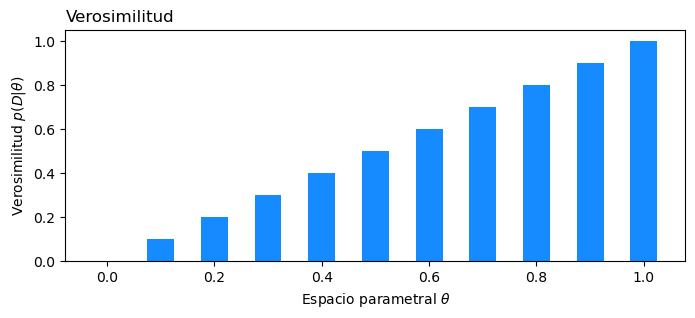

In [5]:
# Valor observado del lanzamiento
y = 1

# Verosimilitud de la observación bajo distintos valores del parámetro
datos['verosim'] = np.apply_along_axis(
    func1d = bernoulli_pdf(y=1)
    ,axis = 0
    ,arr = datos.theta)

# Configuración de figura
fig, ax = plt.subplots(figsize=(8,3))

# Elementos de visualización
ax.bar(
    x = datos.theta
    ,height = datos.verosim
    ,width = 0.05
    ,color = CONFIG['graficas']['colors']['azul'])

# Anotaciones de figura
ax.set_title(f'Verosimilitud', loc='left')
ax.set_xlabel(r'Espacio parametral $\theta$')
ax.set_ylabel(r'Verosimilitud $p(D|\theta)$')

plt.show()

Una vez obtenida la verosimilitud, entonces se reubica mi credibilidad sobre los diferentes parámetros utilizando la regla de Bayes como regla de actualización. Para ello, es necesario calcular la _evidencia_ $p(D)$:

$$p(D) = \sum_{\theta^*}p(D|\theta^*)p(\theta^*)$$

En donde cada uno de los elementos $\theta^*$ son las probabilidades marginales, y la _evidencia_ es la suma de todas las marginales, y la distribución posterior sería entonces:

$$p(\theta|D) = \frac{p(D|\theta)p(\theta)}{p(D)}$$

In [6]:
datos = (
    datos
    .assign(
        marginal = lambda table: table.verosim * table.p_theta
        ,theta_post = lambda table: table.marginal / table.marginal.sum()))

datos

,theta,p_theta,verosim,marginal,theta_post
0,0.0,0.00,0.0,0.000,0.000
1,0.1,0.04,0.1,0.004,0.008
2,0.2,0.08,0.2,0.016,0.032
3,0.3,0.12,0.3,0.036,0.072
4,0.4,0.16,0.4,0.064,0.128
5,0.5,0.20,0.5,0.100,0.200
6,0.6,0.16,0.6,0.096,0.192
7,0.7,0.12,0.7,0.084,0.168
8,0.8,0.08,0.8,0.064,0.128
9,0.9,0.04,0.9,0.036,0.072


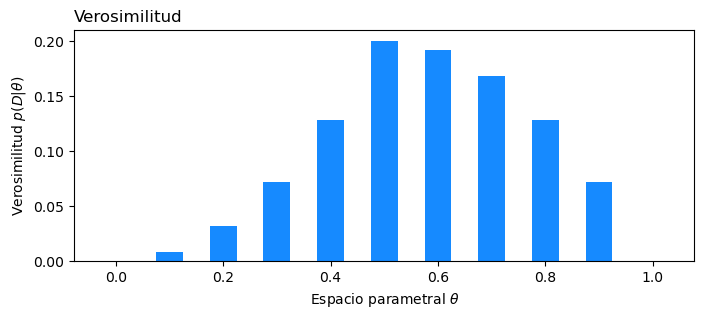

In [7]:
# Configuración de figura
fig, ax = plt.subplots(figsize=(8,3))

# Elementos de visualización
ax.bar(
    x = datos.theta
    ,height = datos.theta_post
    ,width = 0.05
    ,color = CONFIG['graficas']['colors']['azul'])

# Anotaciones de figura
ax.set_title(f'Verosimilitud', loc='left')
ax.set_xlabel(r'Espacio parametral $\theta$')
ax.set_ylabel(r'Verosimilitud $p(D|\theta)$')

plt.show()